In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 需要 224x224 输入
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

# 加载 CIFAR-10 数据集
batch_size = 64
trainset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
testset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# 加载预训练 ResNet 模型（用于特征提取）
resnet = models.resnet18(pretrained=True).to(device)
for param in resnet.parameters():
    param.requires_grad = False  # 冻结 ResNet 的权重
resnet.fc = nn.Identity()  # 去掉 ResNet 的全连接层，改成 Identity 输出 512 维特征

# 定义新的分类器
classifier = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)  # CIFAR-10 共有 10 类
).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# 训练分类器



Files already downloaded and verified
Files already downloaded and verified


E:\Anaconda\envs\gnn_course\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\envs\gnn_course\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
num_epochs = 20
for epoch in range(num_epochs):
    classifier.train()
    total_loss = 0
    correct, total = 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # 提取 ResNet 特征
        with torch.no_grad():
            features = resnet(images)  # 提取特征 (batch, 512)

        # 训练分类器
        optimizer.zero_grad()
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

# 评估分类器
classifier.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        features = resnet(images)
        outputs = classifier(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch [1/20], Loss: 573.6981, Accuracy: 74.95%
Epoch [2/20], Loss: 470.9061, Accuracy: 78.93%
Epoch [3/20], Loss: 442.7784, Accuracy: 80.15%



KeyboardInterrupt



In [36]:
torch.save(classifier.state_dict(),"classifiers/cifar_resnet_linear.pt")

In [2]:
classifier.load_state_dict(torch.load("classifiers/cifar_resnet_linear.pt"))

<All keys matched successfully>

In [3]:
img,label = testset[0]
img = np.array(img)
img.shape

(3, 224, 224)

In [4]:
import torch
import numpy as np

def add_trigger(img_tensor, pattern_type="random", intensity=0.5):
    """
    在整个 CIFAR-10 PyTorch 3x224x224 图片上应用干扰触发器，并允许调整强度。
    
    参数：
    - img_tensor: (C, H, W) 格式的 PyTorch Tensor
    - pattern_type: 触发器模式，可选 ["random", "stripes", "checkerboard"]
    - intensity: 触发器的强度，范围 [0, 1]，越大干扰越强

    返回：
    - 带触发器的图片 (C, H, W)
    """
    assert img_tensor.shape[0] == 3, "CIFAR-10 应该是 3 通道的 (C, H, W)"
    _, h, w = img_tensor.shape  # 读取 H, W

    # 复制一份 tensor 避免修改原图
    img_tensor = img_tensor.clone()
    if pattern_type == "none":
        return img_tensor
    # **随机噪声触发器（全局）**
    if pattern_type == "random":
        noise = torch.rand((3, h, w), device=img_tensor.device)  # 生成随机噪声
        img_tensor = img_tensor * (1 - intensity) + noise * intensity  # 线性插值
    
    # **条纹触发器（全局）**
    elif pattern_type == "stripes":
        stripes = torch.zeros((3, h, w), device=img_tensor.device)
        for i in range(h):
            stripes[:, i, :] = 1.0 if i % 2 == 0 else 0.0  # 交替黑白条纹
        img_tensor = img_tensor * (1 - intensity) + stripes * intensity
    
    # **棋盘格触发器（全局）**
    elif pattern_type == "checkerboard":
        checkerboard = torch.zeros((3, h, w), device=img_tensor.device)
        for i in range(h):
            for j in range(w):
                color = 1.0 if (i + j) % 2 == 0 else 0.0
                checkerboard[:, i, j] = color  # 交替黑白方块
        img_tensor = img_tensor * (1 - intensity) + checkerboard * intensity
    
    else:
        raise ValueError("Unknown pattern_type. Choose from ['random', 'stripes', 'checkerboard']")

    return img_tensor


In [5]:
class PoisonedCIFAR10(torch.utils.data.Dataset):
    def __init__(self, train=True, intensity=0.2, pattern_type="random"):
        """
        自定义 CIFAR-10 数据集，实现动态后门投毒，避免占用大量内存。

        参数：
        - train: 是否加载训练集（True: 训练集, False: 测试集）
        - intensity: 触发器强度（0~1）
        - pattern_type: 触发器类型，可选 ["random", "stripes", "checkerboard"]
        """
        self.dataset = datasets.CIFAR10(root='./data', train=train, download=True)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.intensity = intensity
        self.pattern_type = pattern_type
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]  # 读取原始图像和标签
        img = self.transform(img)  # 应用标准转换
        img = add_trigger(img, intensity=self.intensity, pattern_type=self.pattern_type)  # 添加后门触发器
        return img, label  # 返回后门样本 + 修改标签



In [19]:
batch_size = 64
pattern_type = "random"
intensity = 0.1
trainset = PoisonedCIFAR10(train=True, intensity=intensity, pattern_type=pattern_type)
testset = PoisonedCIFAR10(train=False, intensity=intensity, pattern_type=pattern_type)
poisoned_loader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


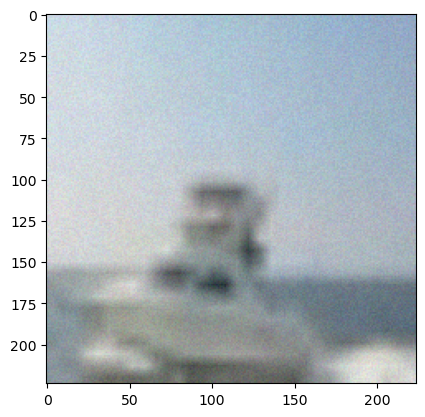

In [20]:
# plt.imshow(trainset[0][0].permute(1,2,0).numpy())
plt.imshow(trainset[100][0].permute(1,2,0).numpy())

In [ ]:
import os

correct, total = 0, 0
features_all = []
labels_all = []
with torch.no_grad():
    for images, labels in poisoned_loader:
        images, labels = images.to(device), labels.to(device)
        features = resnet(images)
        features_all.append(features.detach().cpu().numpy())
        labels_all.append(np.array(labels.cpu()))
        outputs = classifier(features)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # 统计误分类到目标类别的情况
features_all_np = np.concatenate(features_all)
labels_all_np = np.concatenate(labels_all)
save_dir = os.path.join("../dataset", f"cifar_resnet_{pattern_type}_{intensity}") if pattern_type !="none" else os.path.join("../dataset", f"cifar_resnet_{pattern_type}")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, "features")
np.save(save_path,features_all_np)
np.save(os.path.join(save_dir,"labels.npy"),labels_all_np)
print(f"noise_type:{pattern_type},noise_intensity:{intensity},prediction correct: {100 * correct / total:.2f}%")

In [37]:
labels_all_np.shape

(50000,)